In [2]:
%load_ext autoreload
%autoreload 2

from itertools import product
import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/')
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D
from PixelGen.metrics import MultiModalVIMetrics
from sklearn.preprocessing import PowerTransformer
from pathlib import Path


import anndata as ad
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune


from PixelGen.pxl_utils import train_model, get_model_latents
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA
from pixelator.common.statistics import clr_transformation, dsb_normalize


from pixelator.pna.plot import molecule_rank_plot
# from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
# from pixelator.statistics import c
# lr_transformation
# from pixelator.analysis.normalization import dsb_normalize


from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from PixelGen.pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from PixelGen.common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from PixelGen.metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D

import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson, MixtureSameFamily, Beta
from torch.distributions import kl_divergence as kl



# from cytovi import CytoVI

print(torch.cuda.is_available())
from sklearn.decomposition import PCA

from anndata import AnnData
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)

sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

from utils import plot_latent, plot_gene_heatmap, plot_model_latents
from doublet_seperation import B_CD4_logfc_dict, B_CD8_logfc_dict, run_cellwise_coloc_analysis_to_disk, concat_abundance_to_adata, add_doublets_metadata
%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"
from pixelator import read_pna as read
import pickle


Seed set to 0


True
Last run with scvi-tools version: 1.3.3


# SETUP AND ANNOTATION

In [3]:
ANNOTATED_ADATA_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/final_adatas/adata_annotated.h5ad'
DATA_DIR = Path("/home/projects/nyosef/zvise/PxlgnProject/Data")
DOUBLETS_SEP_CACHE='/home/projects/nyosef/zvise/PixelGen/PixelGen/cache/doublet_separation_run'
SEPARATION_PKL_PATH= '/home/projects/nyosef/zvise/PixelGen/PixelGen/cache/results.pkl'
T_CELLS_ADATA_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/final_adatas/t_cell_adata.h5ad'


files = [f for f in DATA_DIR.rglob('*.pxl') if f.is_file()]
pg_data = read(files)

adata=sc.read_h5ad(ANNOTATED_ADATA_PATH)
t_cells= adata[adata.obs['cell_type'].isin(['CD8', 'CD4'])].copy()
t_cells.obsm['arcsinh']=t_cells.layers['arcsinh']

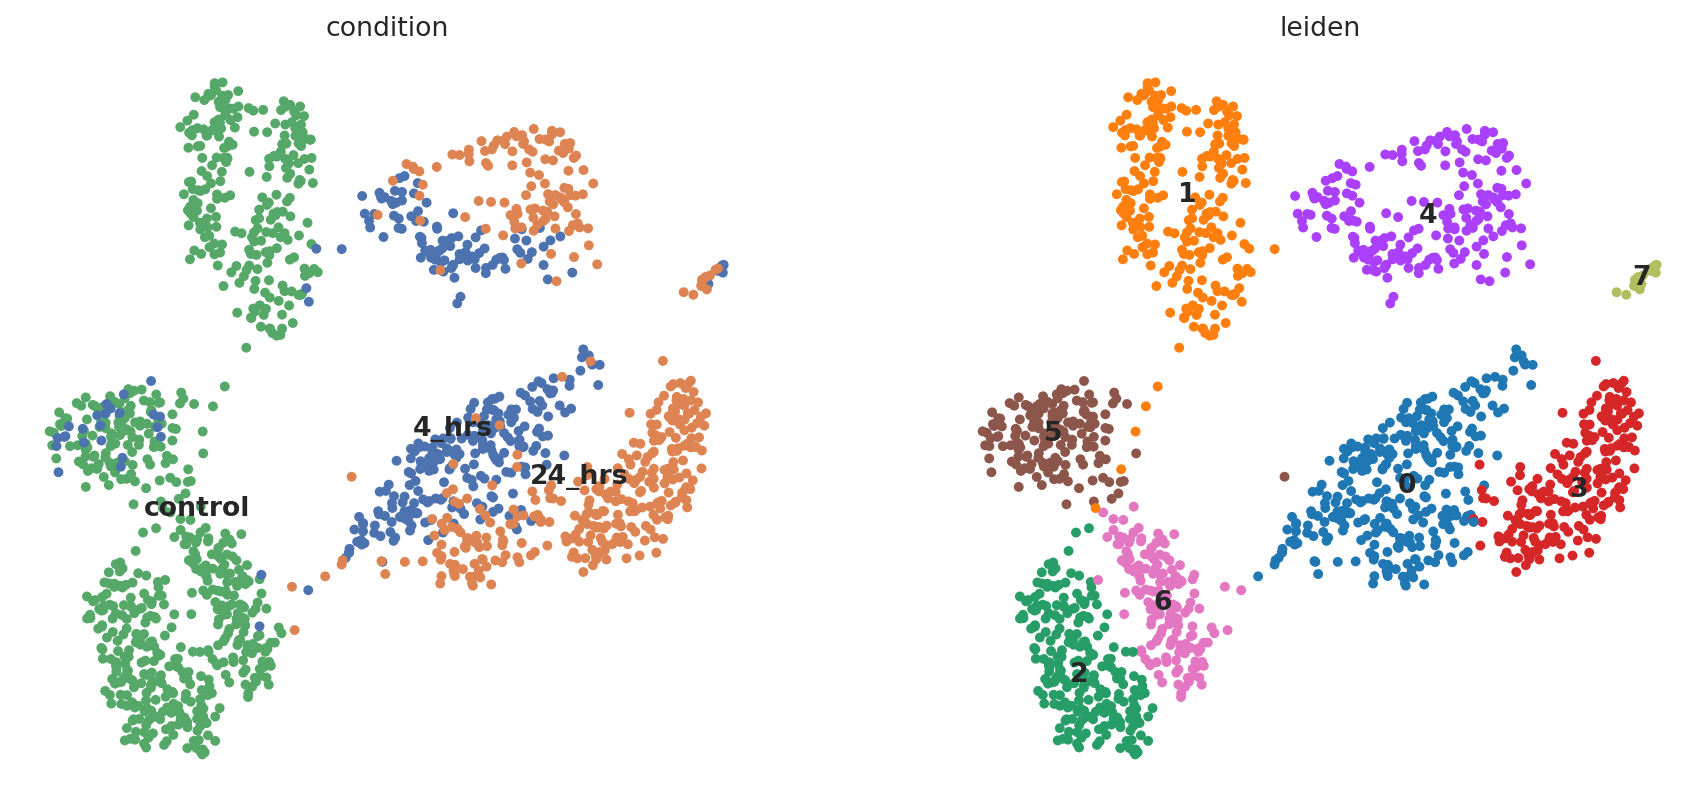

In [67]:
sc.pp.neighbors(t_cells, n_neighbors=15, use_rep="arcsinh")
sc.tl.leiden(t_cells, resolution=0.7)
sc.tl.umap(t_cells)

sc.pl.umap(
    t_cells,
    color=["condition",'leiden'],
    legend_loc='on data',
    ncols=2,
)

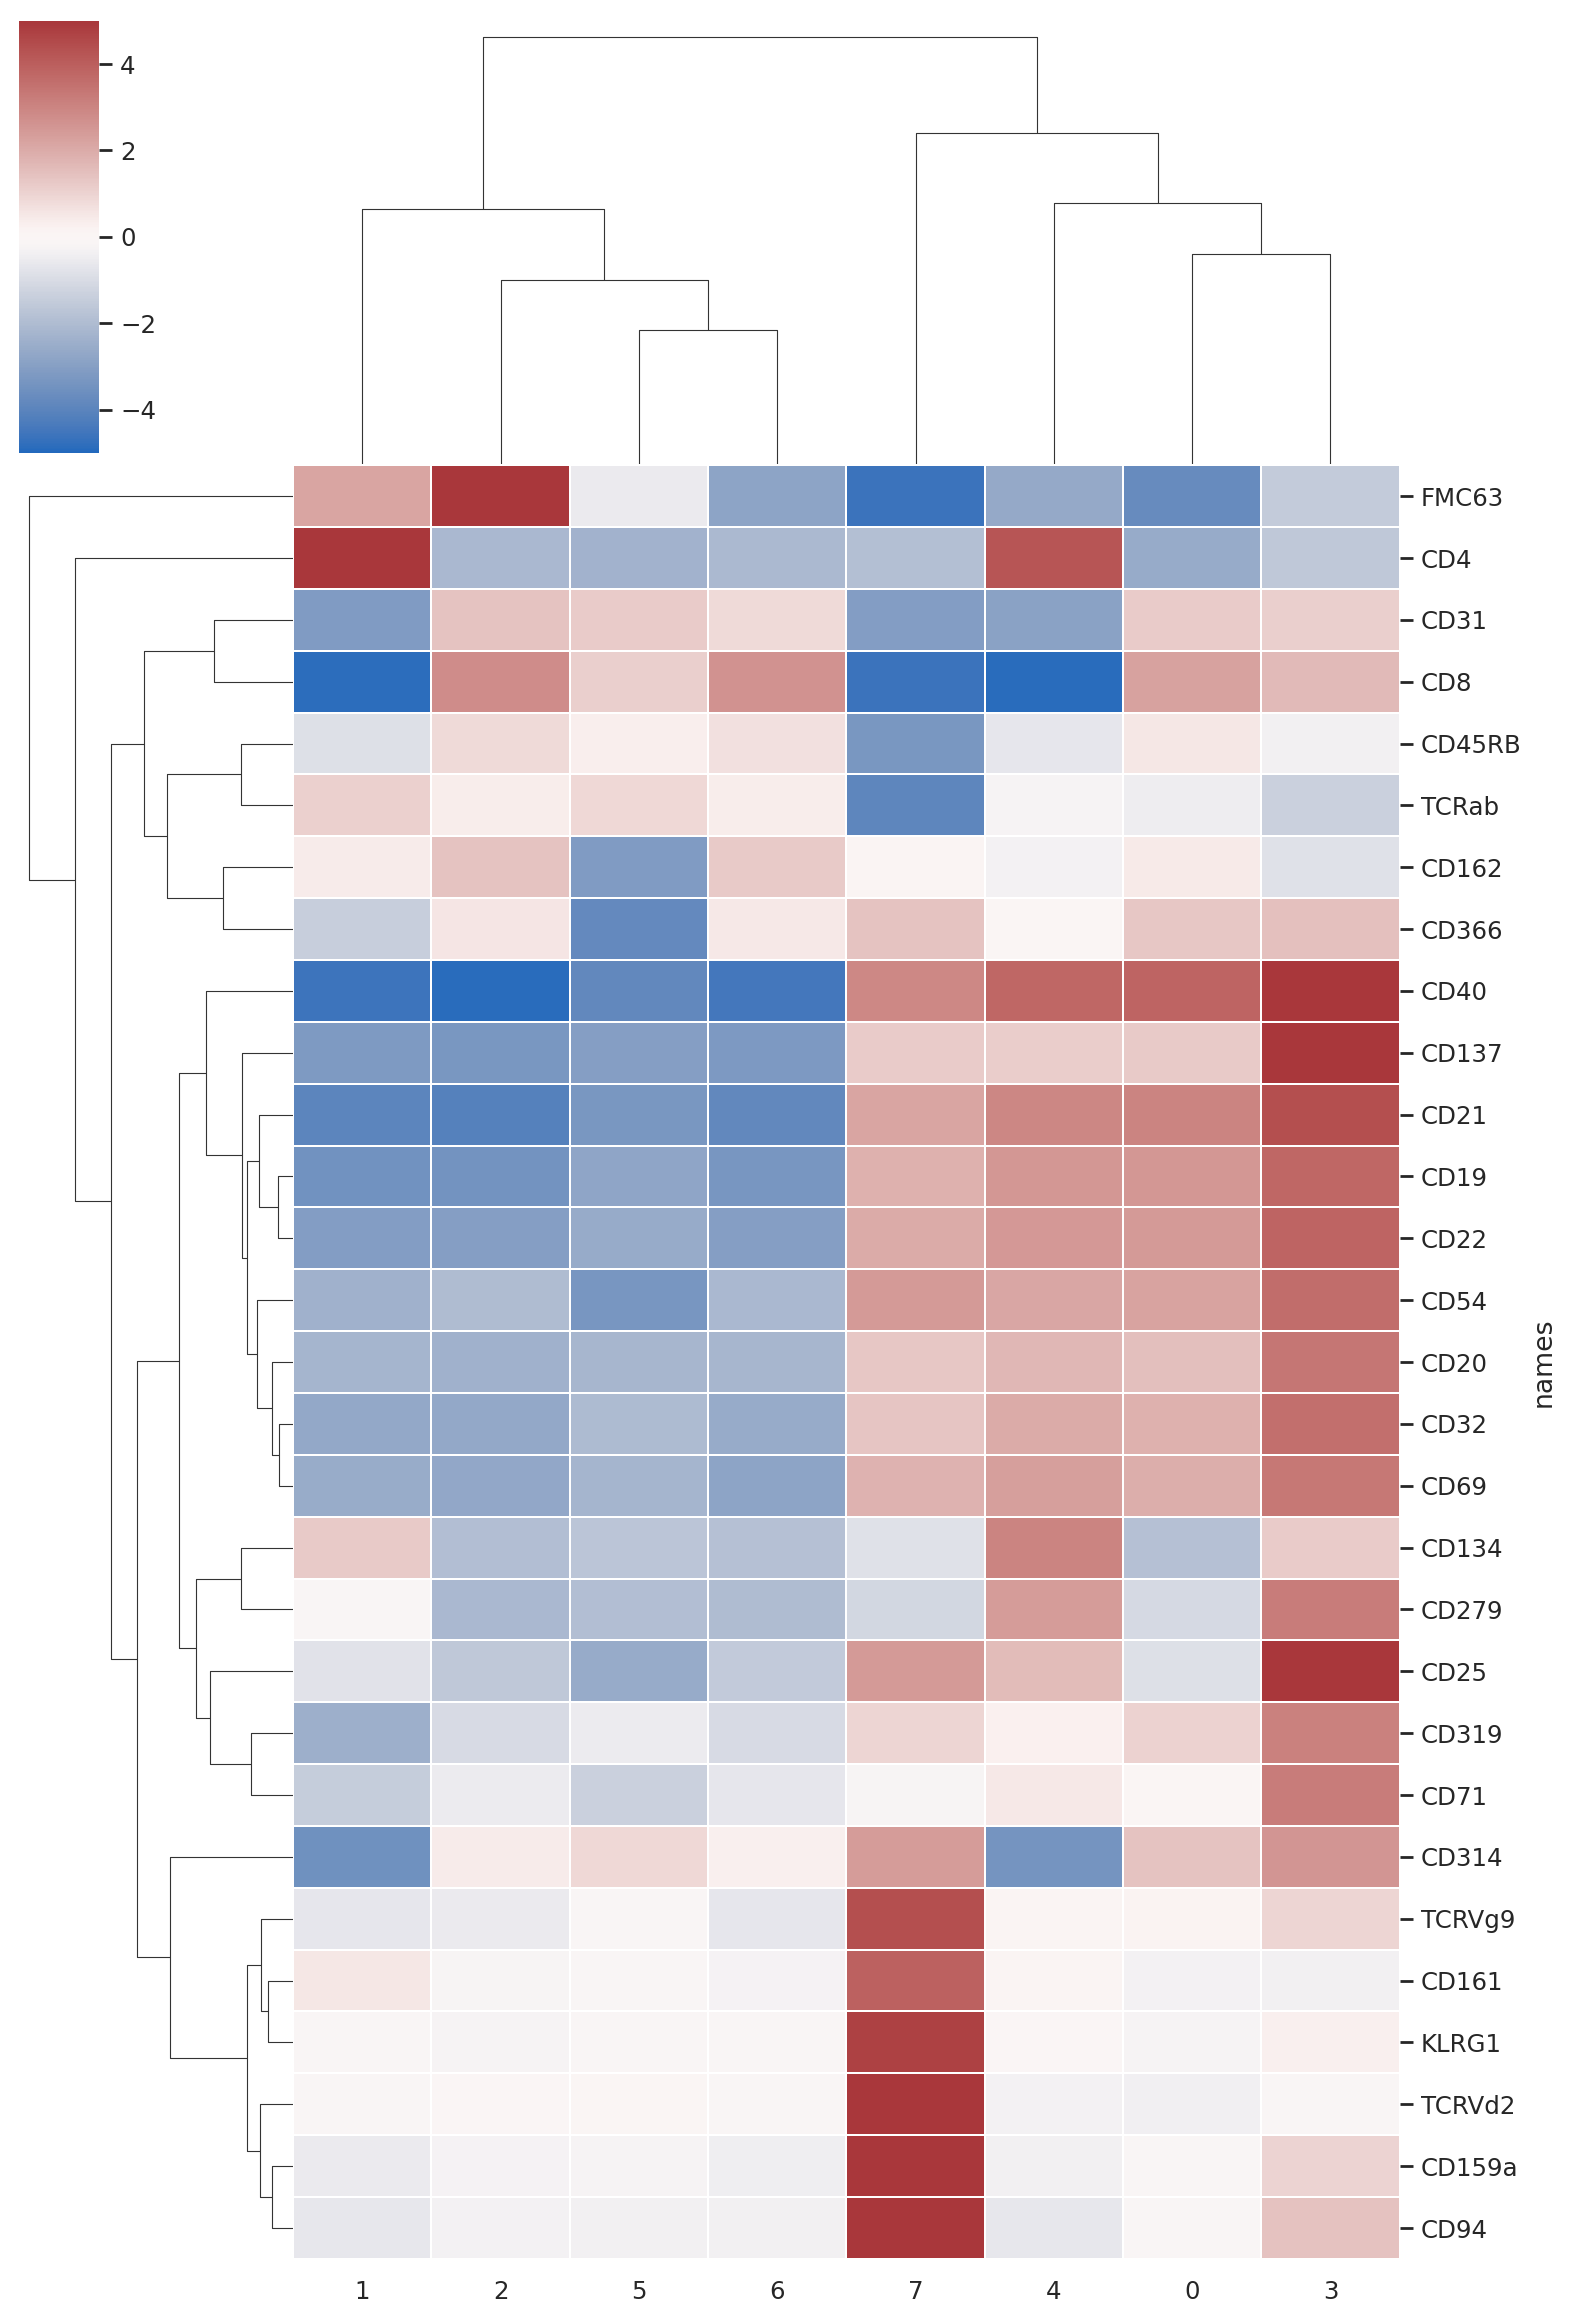

In [68]:
plot_gene_heatmap(t_cells, 'arcsinh','leiden')

In [71]:
cell_annotations = {
    "0": "CD8_doublets",
    "1": "Non_doublets",
    "2": "Non_doublets",
    "3": "CD8_doublets",
    "4": "CD4_doublets",
    "5": "Non_doublets",
    "6": "Non_doublets",
    "7": "Non_doublets",
    
}
t_cells.obs["doublets_status"] = t_cells.obs[
    "leiden"
].map(cell_annotations)



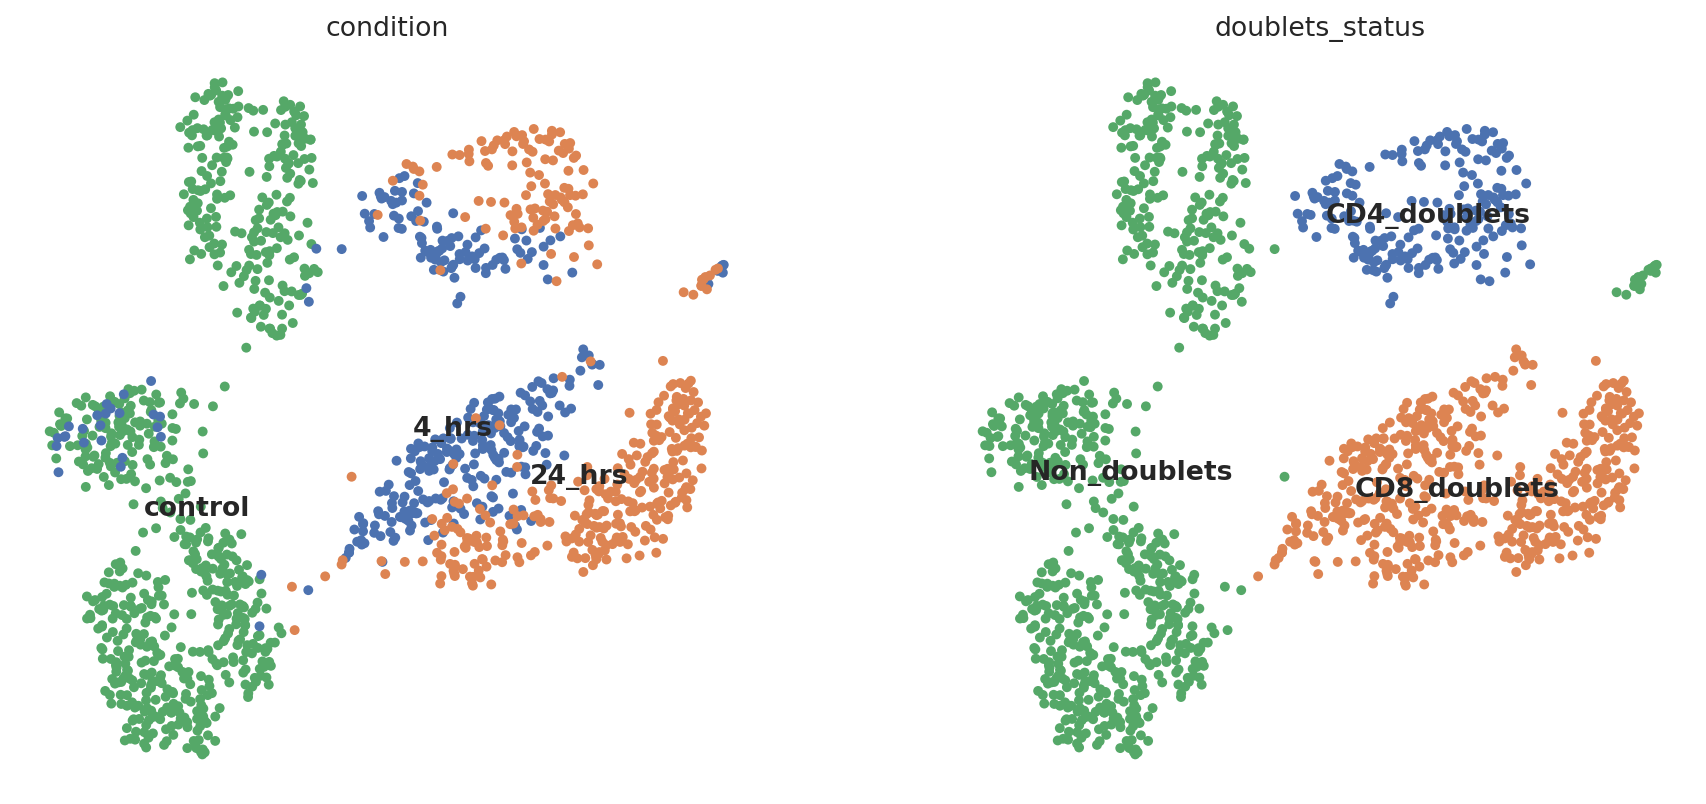

In [72]:
sc.pl.umap(
    t_cells,
    color=["condition",'doublets_status'],
    legend_loc='on data',
    ncols=2,
)

In [106]:
t_cells.obs.doublets_status.value_counts()

doublets_status
Non_doublets    795
CD8_doublets    524
CD4_doublets    202
Name: count, dtype: int64

In [107]:
t_cells.write_h5ad(T_CELLS_ADATA_PATH)

In [ ]:
t_cells = sc.read_h5ad(T_CELLS_ADATA_PATH)


# DOUBLETS SEPARATION

In [16]:
try:
    t_cells
except NameError:
    print("Loading t_cells_adata…")
    t_cells = sc.read_h5ad(T_CELLS_ADATA_PATH)


doublets= t_cells[t_cells.obs['doublets_status'].isin(['CD8_doublets', 'CD4_doublets'])].copy()
doublets

AnnData object with n_obs × n_vars = 726 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'cell_group', 'cell_type_abudnance', 'cell_group_abundance', 'doublets_status'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_group_abundance_colors', 'cell_group_colors', 'cell_type_abudnance_colors', 'cell_type_colors', 'condition_colors', 'doublets_status_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'arcsinh', 'clr', 'log1p', 'pca', 'spatial_asinh', 'spatial_quantile', 'spatial_raw', 'spatial_tanh4', 'z'
    varm: 'PCs'
    layers: 'arcsinh', 'clr', 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [17]:
abundance_all, abundance_scaled_all, zscores_all, coloc_mean_all = (
    run_cellwise_coloc_analysis_to_disk(
        doublets=doublets,
        pg_data=pg_data,
        adata=doublets,
        logfc_cd8=B_CD8_logfc_dict,
        logfc_cd4=B_CD4_logfc_dict,
        out_dir=DOUBLETS_SEP_CACHE,
        k=2,
        n_sims=100,
        seed=123,
        overwrite=False,
        checkpoint_every=50,
    )
)

Processing cells:   0%|          | 0/726 [00:00<?, ?it/s]

💾 Checkpoint saved at iteration 50
💾 Checkpoint saved at iteration 100
💾 Checkpoint saved at iteration 150
💾 Checkpoint saved at iteration 200
💾 Checkpoint saved at iteration 250
💾 Checkpoint saved at iteration 300
💾 Checkpoint saved at iteration 350
💾 Checkpoint saved at iteration 400
💾 Checkpoint saved at iteration 450
💾 Checkpoint saved at iteration 500
💾 Checkpoint saved at iteration 550
💾 Checkpoint saved at iteration 600
💾 Checkpoint saved at iteration 650
💾 Checkpoint saved at iteration 700


In [18]:

with open(SEPARATION_PKL_PATH, "wb") as f:
    pickle.dump(
        dict(
            abundance_all=abundance_all,
            abundance_scaled_all=abundance_scaled_all,
            zscores_all=zscores_all,
            mean_scores=coloc_mean_all
        ),
        f,
        protocol=pickle.HIGHEST_PROTOCOL,
    )


# DOUBLETS ANALYSIS

In [19]:
with open(SEPARATION_PKL_PATH, "rb") as f:
    results = pickle.load(f)

try:
    t_cells
except NameError:
    print("Loading t_cells_adata…")
    t_cells = sc.read_h5ad(T_CELLS_ADATA_PATH)


In [20]:
abundance_all = results["abundance_all"]
abundance_scaled_all = results["abundance_scaled_all"]
zscores_all = results["zscores_all"]
means_all=results['mean_scores']
abundance_all.fillna(0, inplace=True)
abundance_scaled_all.fillna(0, inplace=True)

In [21]:
abundance_scaled_all.shape

(159, 1452)

In [22]:
doublets_cells=t_cells.obs[t_cells.obs.doublets_status.str.startswith('CD')].index
singlets = adata[~adata.obs.index.isin(doublets_cells)].copy()
singlets.X=singlets.layers['counts']


adata_combined = concat_abundance_to_adata(singlets, abundance_scaled_all)


In [27]:
adata_combined=add_doublets_metadata(t_cells, adata_combined)
adata_combined.obsm['combined_arcsinh']=np.arcsinh(adata_combined.X / 5.0).astype(np.float32)
adata_combined.obsm['combined_log1p']=np.log1p(adata_combined.X).astype(np.float32)

adata_combined.obsm['combined_arcsinh']

In [28]:
adata_combined

AnnData object with n_obs × n_vars = 3064 × 159
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'n_antibodies', 'reads_in_component', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'run', 'condition', 'sample_name', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'cell_group', 'cell_type_abudnance', 'cell_group_abundance', 'source', 'region', 'dataset'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear', 'mean', 'std'
    uns: 'neighbors', 'leiden', 'umap', 'condition_colors', 'cell_group_colors', 'dataset_colors'
    obsm: 'X_pca', 'X_umap', 'clr', 'log1p', 'pca', 'spatial_asinh', 'spatial_quantile', 'spatial_raw', 'spatial_tanh4', 'z', 'combined_arcsinh', 'combined_log1p'
    layers: 'arcsinh', 'clr', 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

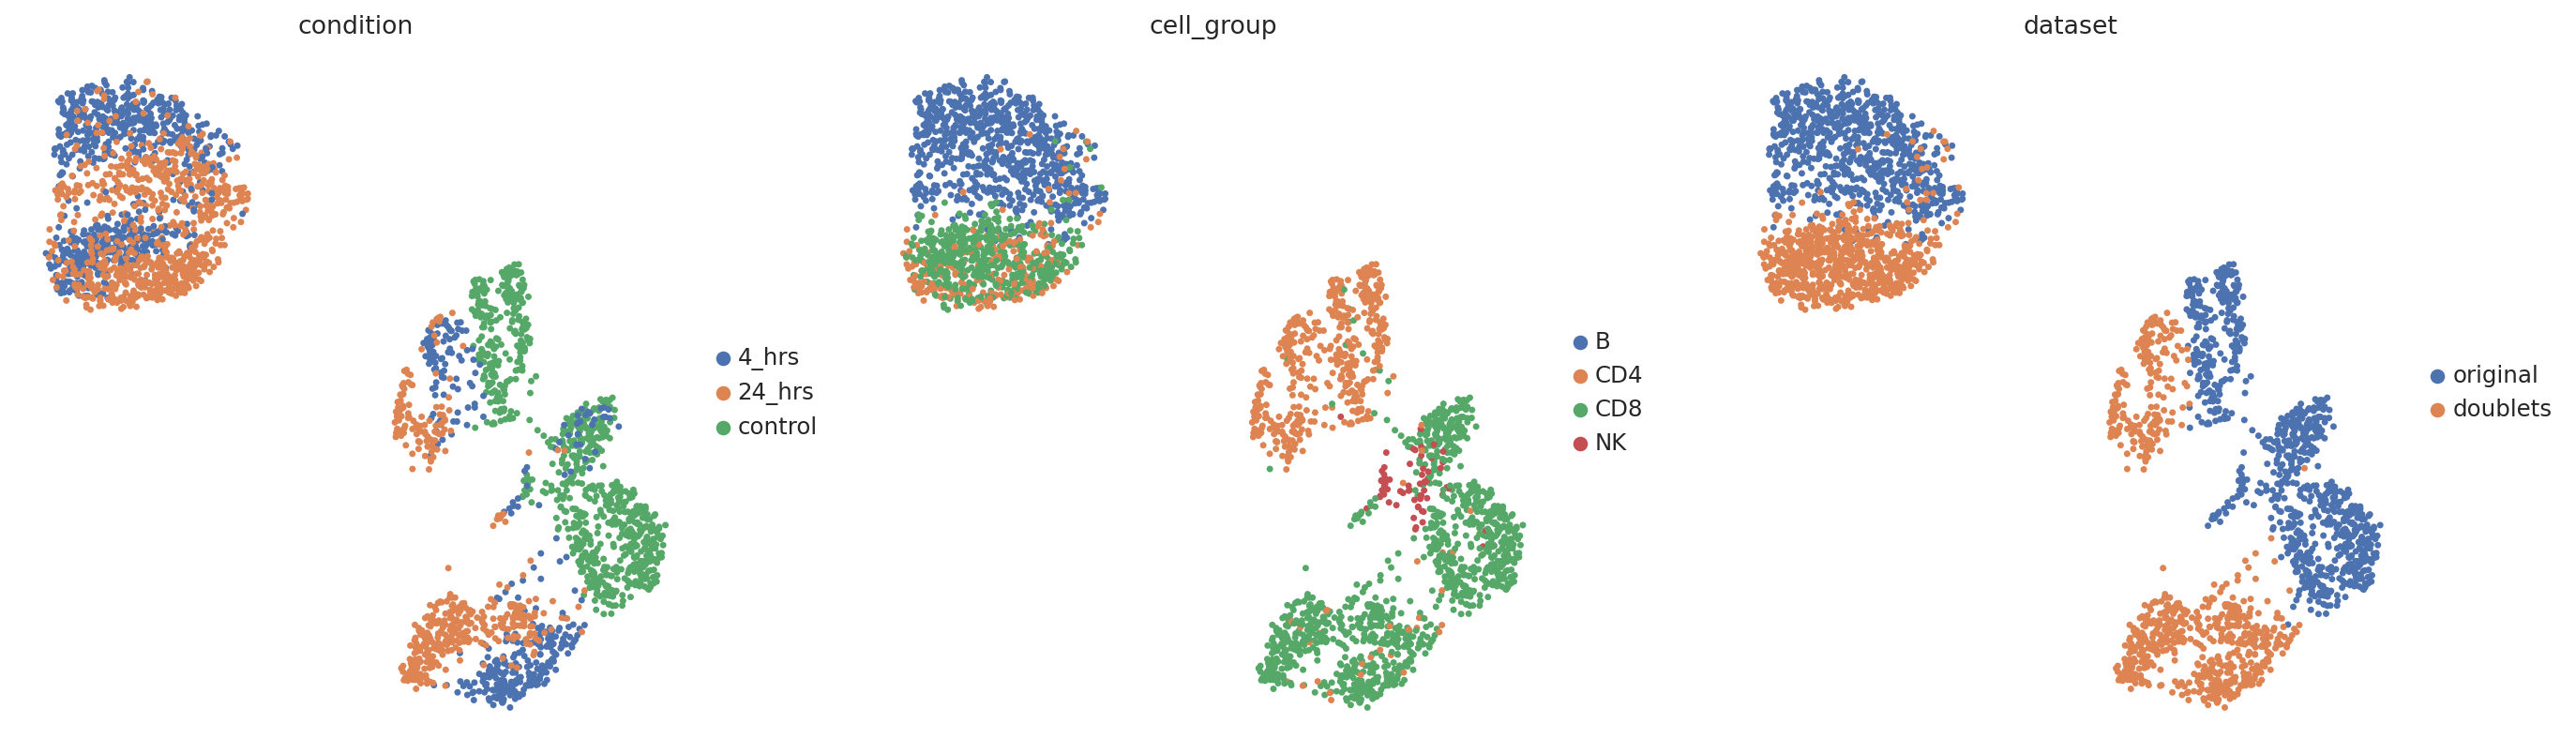

In [30]:
sc.pp.neighbors(adata_combined, n_neighbors=15, use_rep="combined_log1p")
sc.tl.leiden(adata_combined, resolution=0.7)
sc.tl.umap(adata_combined)

sc.pl.umap(
    adata_combined,
    color=["condition",'cell_group','dataset'],
    ncols=3,
)